# Sentence Similarity Identification based on ALBERT

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import copy
import torch.optim as optim
import random
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset, load_metric

os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Load Data

The General Language Understanding Evaluation (GLUE) benchmark (https://gluebenchmark.com/) is a collection of resources for training, evaluating, and analyzing natural language understanding systems. The Microsoft Research Paraphrase Corpus (MRPC) subset of GLUE dataset is a corpus of sentence pairs automatically extracted from online news sources, with human annotations for whether the sentences in the pair are semantically equivalent. 

In [ ]:
dataset = load_dataset('glue', 'mrpc')

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# dataset['train'].to_pandas().to_csv('train.csv',index=None)
# dataset['test'].to_pandas().to_csv('test.csv',index=None)
# dataset['validation'].to_pandas().to_csv('validation.csv',index=None)

In [ ]:
df_train = dataset['train'].to_pandas()
df_val = dataset['test'].to_pandas()
df_test = dataset['validation'].to_pandas()

In [ ]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(3668, 4)
(1725, 4)
(408, 4)


In [ ]:
df_train.head()

,sentence1,sentence2,label,idx
0,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",1,0
1,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,0,1
2,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",1,2
3,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",0,3
4,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,1,4


## Define Dataset and Model

In [ ]:
class CustomDataset(Dataset):
    
    def __init__(self, data, maxlen, with_labels=True, bert_model='albert-base-v2'):

        self.data = data  # pandas dataframe
        # Initialize the tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(bert_model)  

        self.maxlen = maxlen
        self.with_labels = with_labels 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        # Get sentence 1 and sentence 2
        sent1 = str(self.data.loc[index, 'sentence1'])
        sent2 = str(self.data.loc[index, 'sentence2'])

        # Tokenize sentences to get input_ids, attention_mask, token_type_ids
        encoded_pair = self.tokenizer(sent1, sent2,
                                      padding='max_length',
                                      truncation=True,
                                      max_length=self.maxlen,  
                                      return_tensors='pt')
        
        token_ids = encoded_pair['input_ids'].squeeze(0)  # tensor token ids
        attn_masks = encoded_pair['attention_mask'].squeeze(0)  # padded values "0"，other token "1"
        token_type_ids = encoded_pair['token_type_ids'].squeeze(0)  # the first sentence is 0，teh second sentence is 1 # single sentence is 0

        if self.with_labels:  # true if the dataset has labels
            label = self.data.loc[index, 'label']
            return token_ids, attn_masks, token_type_ids, label  
        else:
            return token_ids, attn_masks, token_type_ids

In [ ]:
class SentencePairClassifier(nn.Module):
    
    def __init__(self, bert_model="albert-base-v2", freeze_bert=False):
        super(SentencePairClassifier, self).__init__()
        #  Initialize Bert model
        self.bert_layer = AutoModel.from_pretrained(bert_model)

        #  Encoder hidden size
        if bert_model == "albert-base-v2":  # 12M parameter
            hidden_size = 768
        elif bert_model == "albert-large-v2":  # 18M parameter
            hidden_size = 1024
        elif bert_model == "albert-xlarge-v2":  # 60M parameter
            hidden_size = 2048
        elif bert_model == "albert-xxlarge-v2":  # 235M parameter
            hidden_size = 4096
        elif bert_model == "bert-base-uncased": # 110M parameter
            hidden_size = 768
        elif bert_model == "roberta-base": # 
            hidden_size = 768

        # Freeze Bert layer, udpate output layer
        if freeze_bert:
            for p in self.bert_layer.parameters():
                p.requires_grad = False
                
        self.dropout = nn.Dropout(p=0.1)
        # Output
        self.cls_layer = nn.Linear(hidden_size, 1)


    @autocast()
    def forward(self, input_ids, attn_masks, token_type_ids):
        '''
        Inputs:
            -input_ids : Tensor containing token ids
            -attn_masks : Tensor containing attention masks to be used to focus on non-padded values
            -token_type_ids : Tensor containing token type ids to be used to identify sentence1 and sentence2
        '''

        outputs = self.bert_layer(input_ids, attn_masks, token_type_ids)
        logits = self.cls_layer(self.dropout(outputs['pooler_output']))

        return logits

In [ ]:
def set_seed(seed):
    """ 
    set random seed to make sure reproducibility
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    

def evaluate_loss(net, device, criterion, dataloader):
    """
    evaluation
    """
    net.eval()

    mean_loss = 0
    count = 0

    with torch.no_grad():
        for it, (seq, attn_masks, token_type_ids, labels) in enumerate(tqdm(dataloader)):
            seq, attn_masks, token_type_ids, labels = \
                seq.to(device), attn_masks.to(device), token_type_ids.to(device), labels.to(device)
            logits = net(seq, attn_masks, token_type_ids)
            mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
            count += 1

    return mean_loss / count

In [ ]:
print("Create /models:")
!mkdir models

Create /models:
mkdir: cannot create directory ‘models’: File exists


In [ ]:
def train_bert(net, criterion, opti, lr, lr_scheduler, train_loader, val_loader, epochs, iters_to_accumulate):

    best_loss = np.Inf
    best_ep = 1
    nb_iterations = len(train_loader)
    print_every = nb_iterations // 5
    iters = []
    train_losses = []
    val_losses = []

    scaler = GradScaler()

    for ep in range(epochs):

        net.train()
        running_loss = 0.0
        for it, (seq, attn_masks, token_type_ids, labels) in enumerate(tqdm(train_loader)):

            # To cuda tensor
            seq, attn_masks, token_type_ids, labels = \
                seq.to(device), attn_masks.to(device), token_type_ids.to(device), labels.to(device)
    
            # Training
            with autocast():
                # Obtaining the logits from the model
                logits = net(seq, attn_masks, token_type_ids)

                # Computing loss
                loss = criterion(logits.squeeze(-1), labels.float())
                loss = loss / iters_to_accumulate  # Normalize the loss because it is averaged

            # Backpropagating the gradients
            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            scaler.scale(loss).backward()

            if (it + 1) % iters_to_accumulate == 0:
                # Optimization step
                # scaler.step() first unscales the gradients of the optimizer's assigned params.
                # If these gradients do not contain infs or NaNs, opti.step() is then called,
                # otherwise, opti.step() is skipped.
                scaler.step(opti)
                # Updates the scale for next iteration.
                scaler.update()
                # Learning rate scheduler
                lr_scheduler.step()
                # Zero grads
                opti.zero_grad()

            running_loss += loss.item()

            if (it + 1) % print_every == 0:  # Print training loss information
                print()
                print("Iteration {}/{} of epoch {} complete. Loss : {} "
                      .format(it+1, nb_iterations, ep+1, running_loss / print_every))

                running_loss = 0.0

        val_loss = evaluate_loss(net, device, criterion, val_loader)  # Compute validation loss
        print()
        print("Epoch {} complete! Validation Loss : {}".format(ep+1, val_loss))

        if val_loss < best_loss:
            print("Best validation loss improved from {} to {}".format(best_loss, val_loss))
            print()
            net_copy = copy.deepcopy(net)  # save the best
            best_loss = val_loss
            best_ep = ep + 1

    # Save model
    path_to_model='models/{}_lr_{}_val_loss_{}_ep_{}.pt'.format(bert_model, lr, round(best_loss, 5), best_ep)
    torch.save(net_copy.state_dict(), path_to_model)
    print("The model has been saved in {}".format(path_to_model))

    del loss
    torch.cuda.empty_cache() # clear cache

Set hyperparameters

In [ ]:
bert_model = "albert-base-v2"  # 'albert-base-v2', 'albert-large-v2', 'albert-xlarge-v2', 'albert-xxlarge-v2', 'bert-base-uncased', ...
freeze_bert = False
maxlen = 128
bs = 16
iters_to_accumulate = 2
lr = 2e-5
epochs = 4

## Model Training

In [ ]:
# Set seed
set_seed(1)

# Create training set and validation set
print("Reading training data...")
train_set = CustomDataset(df_train, maxlen, bert_model)
print("Reading validation data...")
val_set = CustomDataset(df_val, maxlen, bert_model)

# DataLoader
train_loader = DataLoader(train_set, batch_size=bs, num_workers=0)
val_loader = DataLoader(val_set, batch_size=bs, num_workers=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = SentencePairClassifier(bert_model, freeze_bert=freeze_bert)

if torch.cuda.device_count() > 1:  # if multiple GPUs
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net)

net.to(device)

criterion = nn.BCEWithLogitsLoss()
opti = AdamW(net.parameters(), lr=lr, weight_decay=1e-2)
num_warmup_steps = 0 # The number of steps for the warmup phase.
num_training_steps = epochs * len(train_loader)  # The total number of training steps
t_total = (len(train_loader) // iters_to_accumulate) * epochs  # Necessary to take into account Gradient accumulation
lr_scheduler = get_linear_schedule_with_warmup(optimizer=opti, num_warmup_steps=num_warmup_steps, num_training_steps=t_total)

train_bert(net, criterion, opti, lr, lr_scheduler, train_loader, val_loader, epochs, iters_to_accumulate)

Reading training data...
Reading validation data...


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_depreca


Iteration 46/230 of epoch 1 complete. Loss : 0.3061587499535602 


 40%|████      | 92/230 [00:16<00:25,  5.40it/s]


Iteration 92/230 of epoch 1 complete. Loss : 0.2999498432745104 


 60%|██████    | 139/230 [00:24<00:14,  6.26it/s]


Iteration 138/230 of epoch 1 complete. Loss : 0.28176639002302417 


 80%|████████  | 185/230 [00:31<00:07,  6.24it/s]


Iteration 184/230 of epoch 1 complete. Loss : 0.23857205555490826 


100%|██████████| 230/230 [00:39<00:00,  5.81it/s]



Iteration 230/230 of epoch 1 complete. Loss : 0.1963310355077619 


100%|██████████| 108/108 [00:06<00:00, 15.51it/s]



Epoch 1 complete! Validation Loss : 0.42950938476456535
Best validation loss improved from inf to 0.42950938476456535



 20%|██        | 47/230 [00:07<00:29,  6.28it/s]


Iteration 46/230 of epoch 2 complete. Loss : 0.21621850489274316 


 40%|████      | 93/230 [00:14<00:21,  6.32it/s]


Iteration 92/230 of epoch 2 complete. Loss : 0.1833103133932404 


 60%|██████    | 139/230 [00:22<00:14,  6.29it/s]


Iteration 138/230 of epoch 2 complete. Loss : 0.16331993318770244 


 80%|████████  | 185/230 [00:29<00:07,  6.32it/s]


Iteration 184/230 of epoch 2 complete. Loss : 0.1508555891316222 


100%|██████████| 230/230 [00:36<00:00,  6.31it/s]



Iteration 230/230 of epoch 2 complete. Loss : 0.10634245249726203 


100%|██████████| 108/108 [00:06<00:00, 15.95it/s]



Epoch 2 complete! Validation Loss : 0.3831238277532436
Best validation loss improved from 0.42950938476456535 to 0.3831238277532436



 20%|██        | 47/230 [00:07<00:28,  6.32it/s]


Iteration 46/230 of epoch 3 complete. Loss : 0.13440796708607156 


 40%|████      | 93/230 [00:14<00:21,  6.32it/s]


Iteration 92/230 of epoch 3 complete. Loss : 0.1131011993502793 


 60%|██████    | 139/230 [00:22<00:14,  6.27it/s]


Iteration 138/230 of epoch 3 complete. Loss : 0.0839476099278292 


 80%|████████  | 185/230 [00:29<00:07,  6.23it/s]


Iteration 184/230 of epoch 3 complete. Loss : 0.10391206545350344 


100%|██████████| 230/230 [00:36<00:00,  6.26it/s]



Iteration 230/230 of epoch 3 complete. Loss : 0.06701752614310902 


100%|██████████| 108/108 [00:06<00:00, 15.83it/s]



Epoch 3 complete! Validation Loss : 0.3760102068384488
Best validation loss improved from 0.3831238277532436 to 0.3760102068384488



 20%|██        | 47/230 [00:07<00:29,  6.28it/s]


Iteration 46/230 of epoch 4 complete. Loss : 0.08687805910797222 


 40%|████      | 93/230 [00:14<00:21,  6.28it/s]


Iteration 92/230 of epoch 4 complete. Loss : 0.04968400489862846 


 60%|██████    | 139/230 [00:22<00:14,  6.31it/s]


Iteration 138/230 of epoch 4 complete. Loss : 0.040833380022693586 


 80%|████████  | 185/230 [00:29<00:07,  6.28it/s]


Iteration 184/230 of epoch 4 complete. Loss : 0.05276209719317115 


100%|██████████| 230/230 [00:36<00:00,  6.30it/s]



Iteration 230/230 of epoch 4 complete. Loss : 0.03645308971728967 


100%|██████████| 108/108 [00:06<00:00, 15.92it/s]



Epoch 4 complete! Validation Loss : 0.3938129919546622
The model has been saved in models/albert-base-v2_lr_2e-05_val_loss_0.37601_ep_3.pt


## Prediction

In [ ]:
print("Creation of the results' folder...")
!mkdir results

Creation of the results' folder...
mkdir: cannot create directory ‘results’: File exists


In [ ]:
def get_probs_from_logits(logits):
    """
    Converts a tensor of logits into an array of probabilities by applying the sigmoid function
    """
    probs = torch.sigmoid(logits.unsqueeze(-1))
    return probs.detach().cpu().numpy()

def test_prediction(net, device, dataloader, with_labels=True, result_file="results/output.txt"):
    """
    Predict the probabilities on a dataset with or without labels and print the result in a file
    """
    net.eval()
    w = open(result_file, 'w')
    probs_all = []

    with torch.no_grad():
        if with_labels:
            for seq, attn_masks, token_type_ids, _ in tqdm(dataloader):# 训练集、验证集
                seq, attn_masks, token_type_ids = seq.to(device), attn_masks.to(device), token_type_ids.to(device)
                logits = net(seq, attn_masks, token_type_ids)
                probs = get_probs_from_logits(logits.squeeze(-1)).squeeze(-1)
                probs_all += probs.tolist()
        else:
            for seq, attn_masks, token_type_ids in tqdm(dataloader): # 没有标签的测试集
                seq, attn_masks, token_type_ids = seq.to(device), attn_masks.to(device), token_type_ids.to(device)
                logits = net(seq, attn_masks, token_type_ids)
                probs = get_probs_from_logits(logits.squeeze(-1)).squeeze(-1)
                probs_all += probs.tolist()

    w.writelines(str(prob)+'\n' for prob in probs_all)
    w.close()

In [ ]:
path_to_model = 'models/albert-base-v2_lr_2e-05_val_loss_0.37601_ep_3.pt'

# path_to_model = '/content/models/...'  # customized trained model

path_to_output_file = 'results/output.txt'

print("Reading test data...")
test_set = CustomDataset(df_test, maxlen, bert_model)
test_loader = DataLoader(test_set, batch_size=bs, num_workers=0)

model = SentencePairClassifier(bert_model)
if torch.cuda.device_count() > 1:  # if multiple GPUs
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

print()
print("Loading the weights of the model...")
model.load_state_dict(torch.load(path_to_model))
model.to(device)

print("Predicting on test data...")
test_prediction(net=model, device=device, 
                dataloader=test_loader, with_labels=True,  # set the with_labels parameter to False if your want to get predictions on a dataset without labels
                result_file=path_to_output_file)
print()
print("Predictions are available in : {}".format(path_to_output_file))

Reading test data...


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Loading the weights of the model...
Predicting on test data...


100%|██████████| 26/26 [00:01<00:00, 15.46it/s]


Predictions are available in : results/output.txt


## Evaluation

In [ ]:
path_to_output_file = 'results/output.txt'

labels_test = df_test['label'] # true labels

probs_test = pd.read_csv(path_to_output_file, header=None)[0]
threshold = 0.6 # you can adjust this threshold for your own dataset
preds_test=(probs_test >= threshold).astype('uint8') # predicted labels using the above fixed threshold

# metric = load_metric("glue", "mrpc")

In [ ]:
pd.read_csv(path_to_output_file, header=None)

,0
0,0.991699
1,0.049866
2,0.057587
3,0.985352
4,0.039948
...,...
403,0.036224
404,0.964355
405,0.992676
406,0.034241


In [ ]:
preds_test

0      1
1      0
2      0
3      1
4      0
      ..
403    0
404    1
405    1
406    0
407    1
Name: 0, Length: 408, dtype: uint8

In [ ]:
from sklearn.metrics import classification_report


In [ ]:
print(classification_report(labels_test,preds_test))


              precision    recall  f1-score   support

           0       0.81      0.79      0.80       129
           1       0.90      0.91      0.91       279

    accuracy                           0.88       408
   macro avg       0.86      0.85      0.85       408
weighted avg       0.87      0.88      0.87       408



In [ ]:
from sklearn.metrics import confusion_matrix


In [ ]:
print(confusion_matrix(labels_test, preds_test))

[[102  27]
 [ 24 255]]


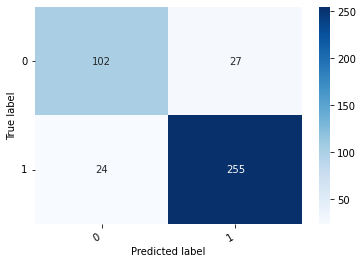

In [ ]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label');

class_names=[0,1]
cm = confusion_matrix(labels_test,preds_test)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)